In [1]:
import sys
import importlib
sys.path.append("/Users/jameshaberberger/GitHub/ate")
from src import utils, models
importlib.reload(utils)
importlib.reload(models)

/opt/homebrew/lib/python3.11/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/opt/homebrew/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN5torch3jit17parseSchemaOrNameERKNSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEE
  Referenced from: <811F03BD-1C6E-37C2-9938-B196923E3A01> /opt/homebrew/lib/python3.11/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <772DF335-D7CB-318F-A275-48A16B0A0CA8> /opt/homebrew/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/opt/homebrew/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/opt/homebrew/lib/python3.11/site-packages/torch_sparse/_version_cpu.so, 0x0006): Symbol not found: __ZN5torch3j

<module 'src.models' from '/Users/jameshaberberger/GitHub/ate/src/models.py'>

In [2]:
import scanpy as sc
adata = sc.read_h5ad("../data/05-27.h5ad")
adata = adata[adata.layers["counts"].sum(axis=1) > 50]

# Data Setup

In [3]:
import torch
data = utils.generate_torch_geometric_data(adata)
data.counts = torch.tensor(adata.layers["counts"].todense(), dtype=torch.float32)
data.near_amyloid = torch.tensor(adata.obs["near_amyloid"].values, dtype=torch.float32)
data.lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values, dtype=torch.float32)
data.total_counts = torch.tensor(adata.layers["counts"].todense().sum(axis=1))
data.size_factors = utils.counts_to_size_factors(data.total_counts)

In [4]:
nb_model = models.GATv2NBNet(data.x.shape[1], 64)

In [ ]:
import wandb

import torch.distributions as dist

logits, dispersion = nb_model(data.x, data.lipid_droplet_area > 0, data.edge_index)

dist.NegativeBinomial(
    logits=logits + data.size_factors.repeat(logits.shape[1], 1).T, 
    total_count=dispersion
).log_prob(data.counts).sum(axis=1).mean()

optimizer = torch.optim.Adam(nb_model.parameters(), lr=1e-3, weight_decay=1e-4)
num_epochs = 1_000

wandb.init(project="ate", name="gatv2_nb_training")

for epoch in range(num_epochs):
    nb_model.train()
    optimizer.zero_grad()
    logits, dispersion = nb_model(data.x, data.lipid_droplet_area > 0, data.edge_index)
    nb_dist = dist.NegativeBinomial(
        logits=logits + data.size_factors.repeat(logits.shape[1], 1).T,
        total_count=dispersion
    )
    log_likelihood = nb_dist.log_prob(data.counts).sum(axis=1).mean()
    loss = -log_likelihood
    loss.backward()
    optimizer.step()
    wandb.log({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})

In [5]:
# torch.save(nb_model, "../models/gatv2_nb_model.pth")
nb_model = torch.load("../models/gatv2_nb_model.pth", weights_only=False)

In [6]:
from tqdm import tqdm
import numpy as np
import torch.distributions as dist

indices = np.arange(adata.shape[0])[
    adata.obs["cell_type"].eq("Astrocyte") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
]

results = {}
for idx in tqdm(indices[::10]):
    # Clone the input features and lipid droplet area
    x_clone = data.x.clone()
    lipid_droplet_area_clone = data.lipid_droplet_area.clone()
    # Set lipid droplet area to 1 for this index
    lipid_droplet_area_clone[idx] = 0.0
    # Run the model
    nb_model.eval()
    with torch.no_grad():
        logits, dispersion = nb_model(x_clone, lipid_droplet_area_clone > 0, data.edge_index)
        results[idx] = logits[idx]

100%|██████████| 354/354 [01:06<00:00,  5.35it/s]


In [9]:
import pandas as pd
treatment = pd.DataFrame(results, index=adata.var_names).T

In [11]:
logits, _ = nb_model(data.x, data.lipid_droplet_area > 0, data.edge_index)
null = pd.DataFrame(
    logits[treatment.index].detach().numpy(), 
    index=treatment.index, 
    columns=adata.var_names
)

Text(0.5, 1.0, 'Average Treatment Effect on HILPDA\nRemoval of Lipid Droplets')

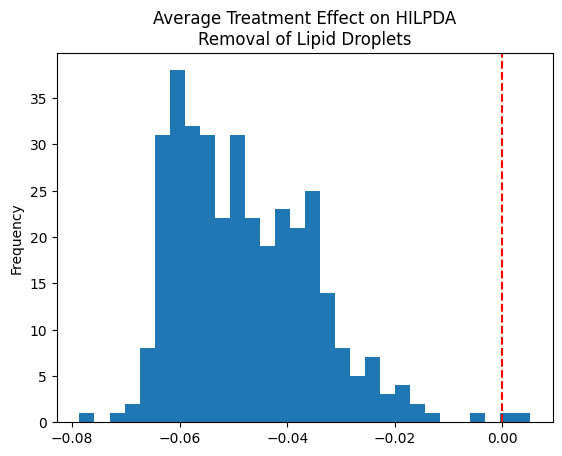

In [99]:
import matplotlib.pyplot as plt
(treatment - null)["HILPDA"].plot.hist(bins=30)
plt.axvline(0, color="red", linestyle="--")
(treatment - null).mean(axis=0).sort_values(ascending=False)
plt.title("Average Treatment Effect on HILPDA\nRemoval of Lipid Droplets")

In [ ]:
from scipy.stats import gamma

# Fit a gamma distribution to each gene's ATE values and test if the mean is significantly different from zero
gamma_results = {}
for gene in ate.columns:
    vals = ate[gene].values
    # Shift data if necessary (gamma is defined for x > 0)
    shift = 0
    if np.any(vals <= 0):
        shift = -vals.min() + 1e-8
        vals = vals + shift
    # Fit gamma distribution
    params = gamma.fit(vals, floc=0)
    shape, loc, scale = params
    # The mean of the fitted gamma is shape * scale - shift
    gamma_mean = shape * scale - shift
    # Compute p-value for mean != 0 (two-sided)
    # Use normal approximation for large samples: mean/s.e.m.
    se = np.std(ate[gene].values, ddof=1) / np.sqrt(len(ate[gene]))
    z = gamma_mean / se
    p_val = 2 * (1 - scipy.stats.norm.cdf(np.abs(z)))
    gamma_results[gene] = {"gamma_mean": gamma_mean, "p_value": p_val}

# Convert to DataFrame
gamma_results_df = pd.DataFrame(gamma_results).T
gamma_results_df["-log10p"] = -np.log10(gamma_results_df["p_value"])
gamma_results_df["delta_logit"] = ate.median(axis=0)
gamma_results_df["mean_expression"] = adata.X.mean(axis=0)


In [ ]:
from scipy.stats import ttest_1samp

ate = (treatment - null)

# Compute t-test statistics for each gene (column) in treatment DataFrame
t_stats = {}
p_values = {}

for gene in ate.columns:
    t_stat, p_val = ttest_1samp(ate[gene], popmean=0)
    t_stats[gene] = t_stat
    p_values[gene] = p_val

# Convert to DataFrames for easier inspection
t_stats_df = pd.DataFrame.from_dict(t_stats, orient='index', columns=['t_stat'])
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])

# Optionally, combine into a single DataFrame
ttest_results = pd.concat([t_stats_df, p_values_df], axis=1)
ttest_results.sort_values('p_value', inplace=True)
ttest_results["-log10p"] = -np.log10(ttest_results["p_value"])
ttest_results["delta_logit"] = ate.median(axis=0)
ttest_results["mean_expression"] = adata.X.mean(axis=0)


Text(83.34722222222221, 0.5, '-log10(p-value)')

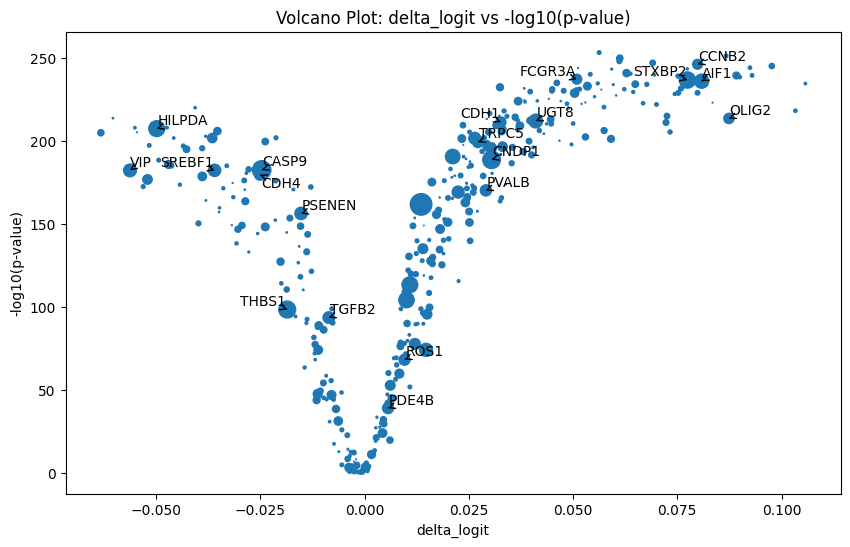

In [97]:
from adjustText import adjust_text

import matplotlib.pyplot as plt

ttest_results.plot.scatter(
    x="delta_logit", 
    y="-log10p", 
    s=adata.X.mean(axis=0) * 100,
    figsize=(10, 6)
)
# Get top 10 most significant genes (lowest p-values) and top 10 least significant (highest p-values)
top10 = ttest_results.query("mean_expression > 0.5").nsmallest(10, "delta_logit")
bottom10 = ttest_results.query("mean_expression > 0.5").nlargest(10, "delta_logit")
texts = [
    plt.text(row["delta_logit"], row["-log10p"], idx, fontsize=10,
             ha='right' if row["delta_logit"] < 0 else 'left')
    for idx, row in pd.concat([top10, bottom10]).iterrows()
]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='k'))

plt.title("Volcano Plot: delta_logit vs -log10(p-value)")
plt.xlabel("delta_logit")
plt.ylabel("-log10(p-value)")